# Prediction of SPY Returns

Exercise on predicting SPY returns for formulation of a trend-following trading strategy.

# Libraries Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf
yf.pdr_override()

import warnings
warnings.filterwarnings("ignore")

# Set Up

Here we define the relevant stock, currency and index tickers for extraction to train the model.

We also define the appropriate timeframe to extract the required data and lag windows.

In [2]:
key_stock = "SPY"
stock_ticker = ["AAPL", "AMZN", "GOOGL", "GIS", "PG",
                "MRK", "AMT", "MCD", "BMY", "DIS",
                "WMT", "MSFT", "DELL", "VMW", "KKR",
                "FERG", "VEEV"]
currency_ticker = ["DEXJPUS", "DEXCHUS", "DEXINUS", "DEXUSEU", "DEXKOUS"]
#index_ticker = ["VIXCLS", "GVZCLS", "DAAA", "DJUA", "WILLMICROCAPPR", "DJTA", "DJIA"]
index_ticker = ["GLD", "VTI", "DIA", "SHV", "RWM"]
windows = [[21, 63, 252],
           [20, 50, 200],
           [12, 50, 200],
           [26, 50, 200],
           [10, 26, 126],
           [5, 21, 126],
           [10, 50, 126],
           ]

start = dt.datetime(2004, 11, 1)
end = dt.datetime(2023, 10, 31)

In [3]:
stock_data = pdr.get_data_yahoo([key_stock]+stock_ticker,
                                start = start,
                                end = end)
currency_data = pdr.get_data_fred(currency_ticker,
                                  start = start,
                                  end = end)
index_data = pdr.get_data_yahoo(index_ticker,
                               start = start,
                               end = end)

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  5 of 5 completed


In [4]:
stock_data.head(3)

Adj Close                                                    \
                AAPL        AMT   AMZN        BMY DELL        DIS FERG   
Date                                                                     
2004-11-01  0.793943  13.572985  1.755  11.573818  NaN  20.303408  NaN   
2004-11-02  0.809837  13.849021  1.812  11.484637  NaN  20.488495  NaN   
2004-11-03  0.837236  13.793813  1.796  11.771996  NaN  20.633348  NaN   

                                     ...     Volume                         \
                  GIS     GOOGL KKR  ...      GOOGL KKR      MCD       MRK   
Date                                 ...                                     
2004-11-01  12.246771  4.905656 NaN  ...  488507004 NaN  4408100  69787997   
2004-11-02  12.207886  4.876627 NaN  ...  453398148 NaN  4254600  67250684   
2004-11-03  12.360656  4.796547 NaN  ...  554992452 NaN  5922500  51887842   

                                                            
                MSFT       PG       SPY VEEV VMW       WMT  
Date                                                        
2004-11-01  72930900  7285200  36720900  NaN NaN   8974600  
2004-11-02  89417100  8559400  56210000  NaN NaN  10796700  
2004-11-03  79666700  6472800  76960200  NaN NaN  11109500  

[3 rows x 108 columns]

In [5]:
currency_data.head(3)

,DEXJPUS,DEXCHUS,DEXINUS,DEXUSEU,DEXKOUS
DATE,,,,,
2004-11-01,106.41,8.2765,45.33,1.2741,1119.0
2004-11-02,106.29,8.2764,45.40,1.2703,1115.0
2004-11-03,106.20,8.2765,45.33,1.2787,1116.0


In [6]:
index_data = index_data["Adj Close"]
index_data.head(3)

,DIA,GLD,RWM,SHV,VTI
Date,,,,,
2004-11-01,64.949402,NaN,NaN,NaN,38.461372
2004-11-02,64.833328,NaN,NaN,NaN,38.370335
2004-11-03,65.594330,NaN,NaN,NaN,38.867458


# Strategies

## Supervised Learning (ARIMA)

In [7]:
# Loading Algorithm

# ARIMA
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [8]:
# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for assessment
from sklearn.metrics import mean_squared_error

In [9]:
class Features:
    """
	Generates required features for training of the ARIMA model.
    Features include lagged values, moving averages, RSI, stochastic oscillator and rate of return.

	Parameters
	----------
	key_stock: str
	Stock ticker for which ARIMA model is used to predict

    stock_ticker: List[str]
	List of stock tickers to be used as endogenous variables for training of ARIMA model

    stock_data: str
	Dataframe of daily stock price and volume information

    currency_data: str
	Dataframe of daily currency exchange rate

    index_data: str
	Dataframe of daily index price and volume information

    return_period: int
	Define the lagged return period

    windows: List[int]
	Used for calculation of short, medium and long term lagged values
	"""
    def __init__(self, key_stock, stock_ticker, stock_data, currency_data, index_data, return_period = 5, windows = [21, 63, 252]):
        self._return_period = return_period
        self._windows = windows
        self._key_stock = key_stock
        self._stock_ticker = stock_ticker
        self._stock_data = stock_data.copy()
        self._currency_data = currency_data.copy()
        self._index_data = index_data.copy()

    def get_stock_tickers(self):
        return self._stock_ticker

    def get_currency_tickers(self):
        return self._currency_data.columns

    def get_index_tickers(self):
        return self._index_data.columns
        
    def get_return_period(self):
        return self._return_period

    def get_window(self):
        return self._windows

    def dependent_variable(self):
        Y = (np.log(self._stock_data.loc[ : , ("Adj Close", self._key_stock)]).diff(self._return_period).shift(-self._return_period))
        Y.name = (self._key_stock + "_actual")
        return Y

    def related_stock_lags(self):
        df = (np.log(self._stock_data.loc[ : , ("Adj Close", tuple(self._stock_ticker))]).diff(self._return_period))
        df.columns = (df.columns.droplevel())
        return df

    def currency_lags(self):
        df = (np.log(self._currency_data).diff(self._return_period))
        return df

    def index_lags(self):
        df = (np.log(self._index_data).diff(self._return_period))
        return df

    def stock_lags(self):
        df = (pd.concat([np.log(self._stock_data.loc[ : , ("Adj Close", self._key_stock)]).diff(i) for i in [self._return_period, 
                                                                                                             self._return_period * 3, 
                                                                                                             self._return_period * 6, 
                                                                                                             self._return_period * 12]
                        ],
                        axis = 1
                       ).dropna()
             )
        df.columns = [f"{self._key_stock}_DT", f"{self._key_stock}_3DT", f"{self._key_stock}_6DT", f"{self._key_stock}_12DT"]
        return df

    def moving_averages(self):
        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            df = pd.concat([df, self._stock_data.loc[ : , ("Adj Close", self._key_stock)].rolling(window = i).agg(["mean"])],
                            axis = 1)
            COLS.append(f"{self._key_stock}_MA_{i}")
        df.columns = COLS
        df = df.dropna()
        return df

    def exponential_moving_average(self):
        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            df = pd.concat([df, self._stock_data.loc[ : , ("Adj Close", self._key_stock)].ewm(span = i,
                                                                                               min_periods = i)
                                                                                          .mean()],
                            axis = 1
                           )
            COLS.append(f"{self._key_stock}_EWM_{i}")
        df.columns = COLS
        df = df.dropna()
        return df

    def RSI(self, RS_Window):
        data = self._stock_data.loc[ : , ("Adj Close", self._key_stock)].to_frame().dropna()
        data.columns = ["Adj Close"]
        data["Diff"] = data["Adj Close"].diff()
        data.dropna(inplace = True)
        data["Gain"] = np.where(data["Diff"] > 0, data["Diff"], 0)
        data["Loss"] = np.where(data["Diff"] < 0, np.abs(data["Diff"]), 0)
        data["Gain_Mean"] = data["Gain"].rolling(window = RS_Window).mean()
        data["Loss_Mean"] = data["Loss"].rolling(window = RS_Window).mean()
        data["RS"] = pd.Series()
        data["RS"].iloc[RS_Window - 1] = (data["Gain_Mean"].iloc[RS_Window - 1] / data["Loss_Mean"].iloc[RS_Window - 1])
    
        for idx in range(RS_Window, len(data)):
            data["RS"].iloc[idx] =\
                (
                    (data["Gain_Mean"].iloc[idx - 1] * (RS_Window - 1) + data["Gain"].iloc[idx])
                    /
                    (data["Loss_Mean"].iloc[idx - 1] * (RS_Window - 1) + data["Loss"].iloc[idx])
                )
    
        data["RSI"] =\
            (
                100 - (100 / (1 + data["RS"]))
            )
    
        data.dropna(inplace = True)

        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            df = pd.concat([df, data.loc[ : , ("RSI")].rolling(window = i).agg(["mean"])],
                           axis = 1
                          )
            COLS.append(f"{self._key_stock}_RSI_{i}")
        df.columns = COLS
        df = df.dropna()
        return df

    def stochastic_osc(self):
        stoc_osc = self._stock_data.loc[ : , (["Adj Close", "Low", "High"], self._key_stock)]
        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            K =\
            (
                (stoc_osc["Adj Close"] - stoc_osc["Low"].rolling(window = i).min()) 
                /
                (stoc_osc["High"].rolling(window = i).max() - stoc_osc["Low"].rolling(window = i).min())
            )
            COLS.append(f"{self._key_stock}_K_{i}")
            
            D = K.rolling(window = i).mean()
            COLS.append(f"{self._key_stock}_D_{i}")
            
            df = (pd.concat([df, K, D],
                           axis = 1
                          )
                    .dropna()
                 )
        df.columns = COLS
        return df

    def rate(self):
        df = pd.DataFrame()
        COLS = []
        data = self._stock_data.loc[ : , ("Adj Close", self._key_stock)]
        for i in self._windows:
            df = pd.concat([df, data / data.shift(i)],
                            axis = 1
                           )
            COLS.append(f"{self._key_stock}_RATE_{i}")
        df.columns = COLS
        df = df.dropna()
        return df


### Randomized features search

In [10]:
feature_set = {}
for i in range(100):
    pick_stocks = [key_stock] + list(np.random.choice(stock_ticker, 5, replace = False))
    pick_currency = list(np.random.choice(currency_ticker, 2, replace = False))
    pick_index = list(np.random.choice(index_ticker, 3, replace = False))
    pick_period = np.random.choice(5) + 1
    pick_windows = windows[np.random.choice(len(windows))]
    feature_set[f"Set_{i}"] = Features(key_stock,
                                       pick_stocks,
                                       stock_data.loc[ : ,(["Adj Close", "Close", "High", "Low", "Open", "Volume"], tuple(pick_stocks))],
                                       currency_data[pick_currency],
                                       index_data[pick_index],
                                       return_period = pick_period,
                                       windows = pick_windows)

In [11]:
feature_data = {}
for set, features in feature_set.items():
    variables = (
                    pd
                    .concat([features.dependent_variable(),
                             features.related_stock_lags(),
                             features.currency_lags(),
                             features.index_lags(),
                             features.stock_lags(),
                             features.moving_averages(),
                             features.exponential_moving_average(),
                             features.RSI(14),
                             features.stochastic_osc(),
                             features.rate()],
                            axis = 1)
                    .dropna()
                    .iloc[ : :features.get_return_period(), :]
                )
    feature_data[set] = variables

In [12]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_ARIMA_model(arima_order):
    
    modelARIMA = stats.ARIMA(endog = Y_train,
                             exog = X_train_ARIMA,
                             order = arima_order)
    
    model_fit = modelARIMA.fit()
    
    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    
    return error

In [13]:
def assess_models(p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    
                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )
                    
                except:
                    continue
    # print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
    #       )
    return best_cfg

In [14]:
def return_Cumulative_Df(actual_values, predicted_values):
    predicted_values.index = actual_values.index
    df = pd.DataFrame([actual_values, predicted_values]).T
    df.columns = ["Actual_Returns" ,"Predicted_Returns"]
    
    # Simple trend following strategy
    df["trend_follow_signal"] = np.where(df["Predicted_Returns"] > 0, 1, -1)
    df["trend_Strategy_Returns"] = df["trend_follow_signal"].shift(1) * df["Actual_Returns"]
    df["trend_Cummulative_Returns"] = np.exp(df["trend_Strategy_Returns"].cumsum())
    
    return df

### ARIMA model training and evaluation

Only feature sets that generated more than 2x returns in the test set is shortlisted for in-sample period testing.

In [15]:
good_returns = {}

for set, data in feature_data.items():
    
    Y = data.loc[ : , data.columns[0]]
    X = data.loc[ : , data.columns[1:]]
    
    validation_size = 0.4 # this refers to testing set
    train_size = int(len(X) * (1 - validation_size))
    X_train, X_test = (X[0:train_size], X[train_size:len(X)])
    Y_train, Y_test = (Y[0:train_size], Y[train_size:len(X)])
    
    # Basic Set-up for ARIMA
    COLS = list(X.columns[1:10])
    X_train_ARIMA = (X_train.loc[ : , COLS])
    X_test_ARIMA = (X_test.loc[ : , COLS])
    
    train_len = len(X_train_ARIMA)
    test_len = len(X_test_ARIMA)
    total_len = len(X)
    
    # p_values = [0, 1, 2]
    # d_values = range(0, 2)
    # q_values = range(0, 2)
    # p, d, q = assess_models(p_values, d_values, q_values)
    
    modelARIMA = (stats.ARIMA(endog = Y_train,
                              exog = X_train_ARIMA,
                              order = [2, 0, 0]
                             )
                 )
    
    model_fit = modelARIMA.fit()
    
    train_len = len(X_train_ARIMA)
    test_len = len(X_test_ARIMA)
    total_len = len(X)
    
    predicted_test = (model_fit.predict(start = train_len - 1,
                                        end = total_len - 1,
                                        exog = X_test_ARIMA)[1: ]
                     )
    backtest_Test_Sample = return_Cumulative_Df(Y_test, predicted_test)
    final_returns = backtest_Test_Sample["trend_Cummulative_Returns"][-1]

    if final_returns > 2.0:
        predicted_InSample = (model_fit.predict(start = 0,
                                                end = total_len - 1,
                                                exog = X_test_ARIMA)
                             )
        backtest_In_Sample = return_Cumulative_Df(Y, predicted_InSample)
    
        good_returns[set] = (final_returns, backtest_Test_Sample, backtest_In_Sample)

/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/base/model.py:607: Convergence

In [16]:
for set in good_returns.keys():
    print(f"\n{set}:")
    print(f"{feature_set[set].get_currency_tickers()}\n"
          f"{feature_set[set].get_index_tickers()}\n"
          f"{feature_set[set].get_return_period()}\n"
          f"{feature_set[set].get_stock_tickers()}\n"
          f"{feature_set[set].get_window()}")


Set_3:
Index(['DEXJPUS', 'DEXUSEU'], dtype='object')
Index(['GLD', 'SHV', 'RWM'], dtype='object')
2
['SPY', 'VMW', 'WMT', 'MSFT', 'GOOGL', 'PG']
[10, 26, 126]

Set_10:
Index(['DEXCHUS', 'DEXINUS'], dtype='object')
Index(['GLD', 'VTI', 'SHV'], dtype='object')
3
['SPY', 'KKR', 'GIS', 'DIS', 'FERG', 'AMT']
[12, 50, 200]

Set_21:
Index(['DEXINUS', 'DEXKOUS'], dtype='object')
Index(['DIA', 'SHV', 'GLD'], dtype='object')
3
['SPY', 'GIS', 'WMT', 'AAPL', 'MRK', 'MCD']
[26, 50, 200]

Set_34:
Index(['DEXJPUS', 'DEXCHUS'], dtype='object')
Index(['GLD', 'RWM', 'VTI'], dtype='object')
4
['SPY', 'PG', 'AAPL', 'GIS', 'AMT', 'MSFT']
[21, 63, 252]

Set_38:
Index(['DEXKOUS', 'DEXCHUS'], dtype='object')
Index(['GLD', 'SHV', 'VTI'], dtype='object')
3
['SPY', 'WMT', 'MSFT', 'BMY', 'MRK', 'MCD']
[10, 50, 126]

Set_45:
Index(['DEXINUS', 'DEXKOUS'], dtype='object')
Index(['DIA', 'GLD', 'VTI'], dtype='object')
2
['SPY', 'FERG', 'BMY', 'PG', 'AMZN', 'GIS']
[12, 50, 200]


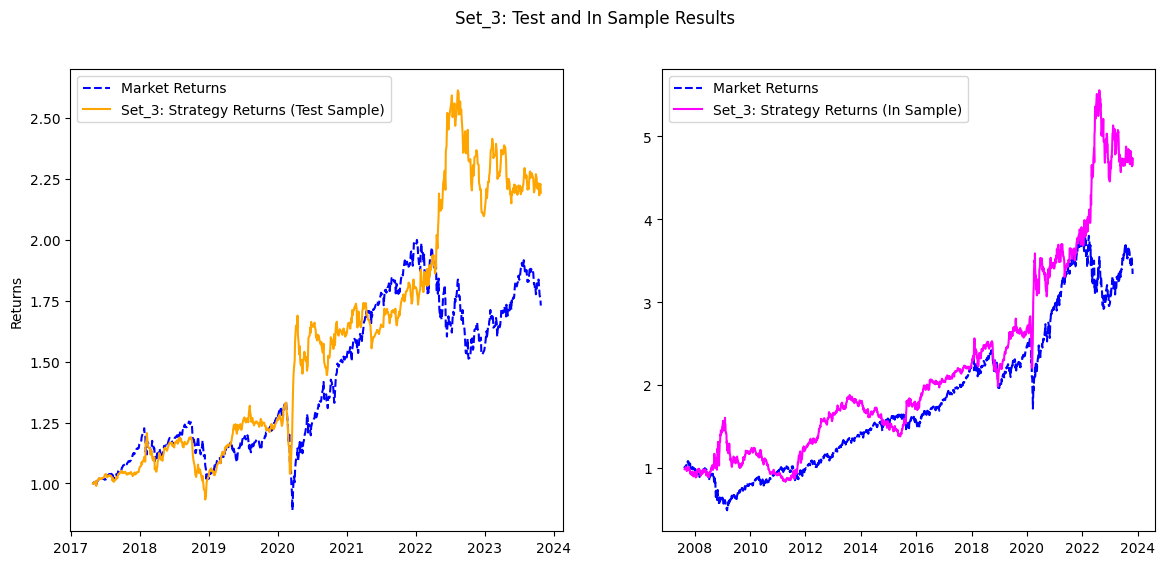

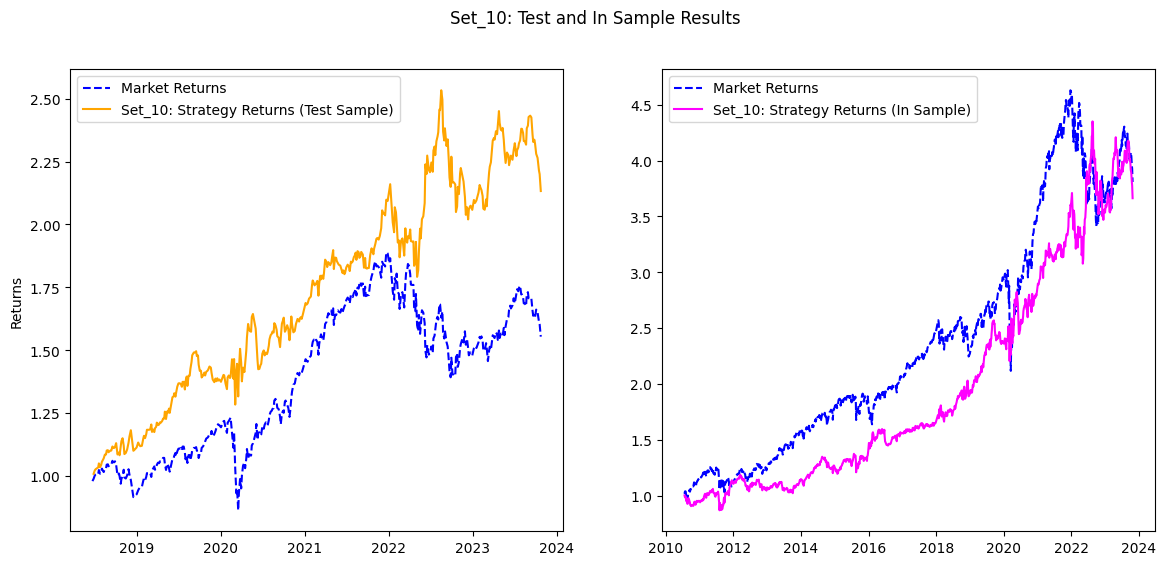

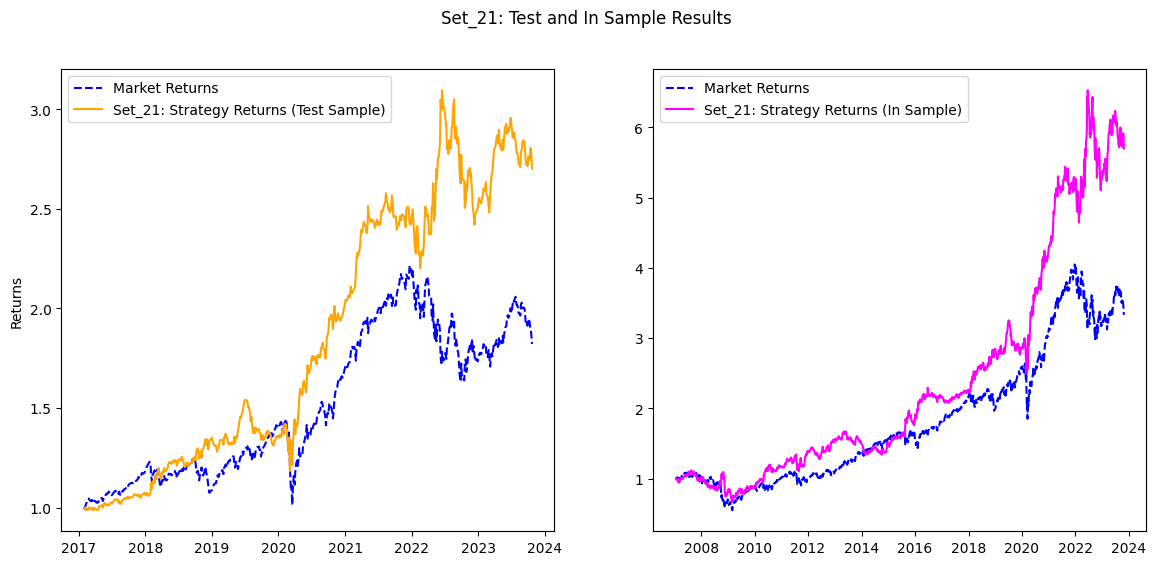

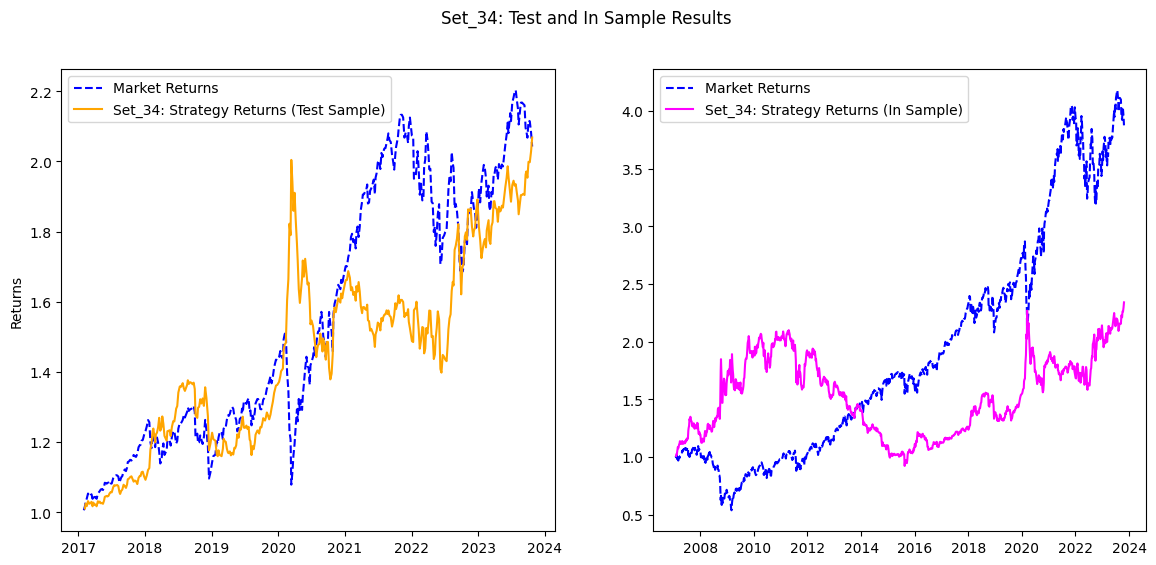

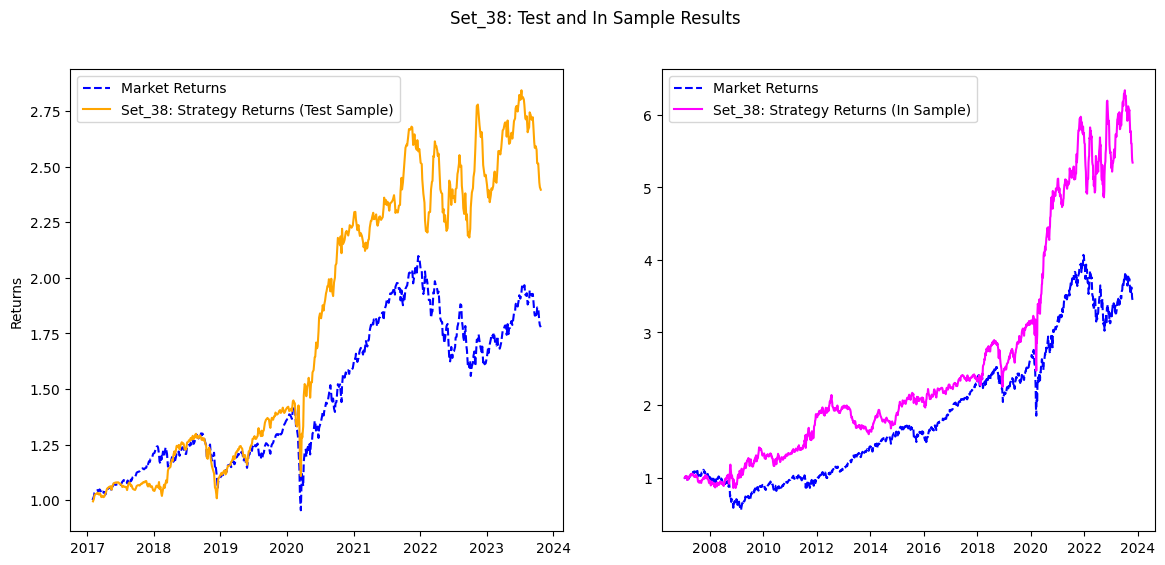

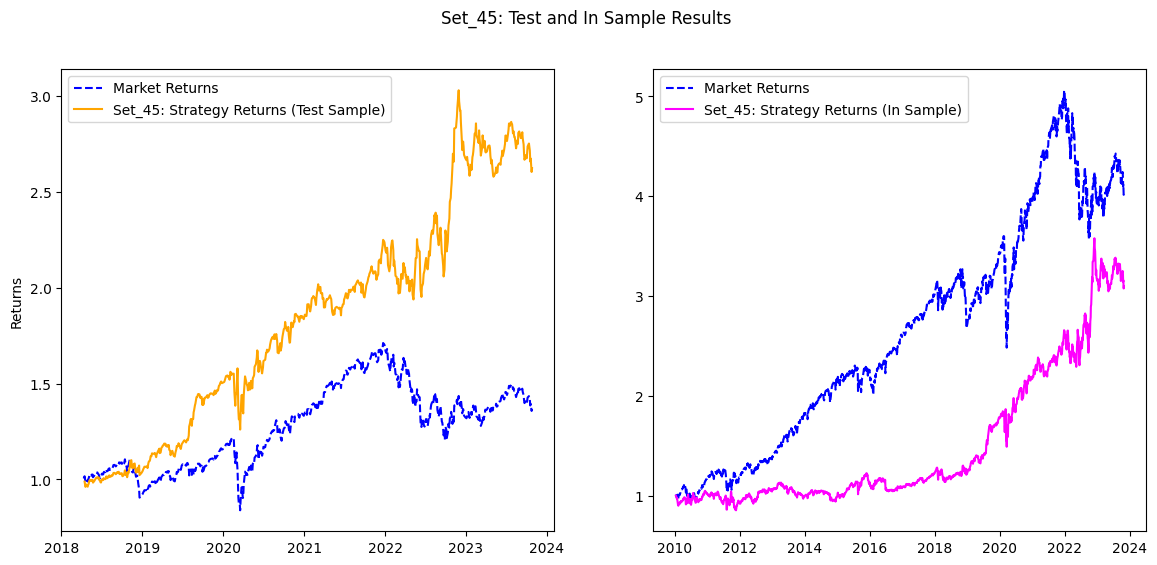

In [17]:
for set, (_, testsample, insample) in good_returns.items():
    fig, axs = plt.subplots(1, 2, figsize = (14,6))
    fig.suptitle(f"{set}: Test and In Sample Results")
    axs[0].plot(np.exp(testsample["Actual_Returns"]).cumprod(), "b--", label = "Market Returns")
    axs[0].plot(testsample["trend_Cummulative_Returns"], "orange", label = f"{set}: Strategy Returns (Test Sample)")
    axs[0].legend(loc="upper left")
    axs[0].set_ylabel("Returns")
    axs[1].plot(np.exp(insample["Actual_Returns"]).cumprod(), "b--", label = "Market Returns")
    axs[1].plot(insample["trend_Cummulative_Returns"], "magenta", label = f"{set}: Strategy Returns (In Sample)")
    axs[1].legend(loc="upper left")

# Performance Measurements

## Max Drawdown Periods

In [18]:
def calculate_max_drawdown_periods(df, cum_returns_col):
    df["Max_Gross_Performance"] = df[cum_returns_col].cummax()
    df["Drawdown"] = df["Max_Gross_Performance"] - df[cum_returns_col]
    drawdowns = df[df["Drawdown"] == 0][["Drawdown"]]
    periods = pd.to_timedelta(drawdowns.index[1: ] - drawdowns.index[ :-1]).days.values
    
    max_dd = []
    start = drawdowns.index[0]
    end = drawdowns.index[0]
    
    for duration in periods:
        end += dt.timedelta(days = int(duration))
        max_pct = df["Drawdown"].loc[start:end].max()
        max_dd.append(max_pct*100)
        start += dt.timedelta(days = int(duration))
        
    drawdown_data = pd.concat([pd.Series(periods), pd.Series(max_dd)],
                                          axis = 1,
                                          keys = ["Drawdown Period", "Max Drawdown"]) \
                    .sort_values(by = "Max Drawdown",
                                 ascending = False,
                                 ignore_index = True)

    return drawdown_data

In [19]:
for set, (_, testsample, insample) in good_returns.items():
    
    drawdown_data_test_sample = calculate_max_drawdown_periods(testsample, "trend_Cummulative_Returns")
    print(f"{set} (Test Sample):\n {drawdown_data_test_sample.head()}")
    
    drawdown_data_in_sample = calculate_max_drawdown_periods(insample, "trend_Cummulative_Returns")
    print(f"{set} (In Sample):\n {drawdown_data_in_sample.head()}")

Set_3 (Test Sample):
    Drawdown Period  Max Drawdown
0               38     29.194919
1              457     27.298199
2              289     24.412199
3              199     18.582404
4               30     12.465840
Set_3 (In Sample):
    Drawdown Period  Max Drawdown
0             1367     77.127615
1               38     62.053119
2              457     58.021686
3              289     51.887558
4              944     49.635755
Set_10 (Test Sample):
    Drawdown Period  Max Drawdown
0              153     36.806768
1              229     21.954089
2              191     21.197821
3               30     12.922722
4              167      9.541655
Set_10 (In Sample):
    Drawdown Period  Max Drawdown
0              153     63.209639
1              229     37.702578
2              191     36.403811
3               30     22.192674
4              182     19.155819
Set_21 (Test Sample):
    Drawdown Period  Max Drawdown
0              259     37.607990
1              298     35.762878


## Sharpe Ratio

In [20]:
def calculate_sharpe_ratio(ts_returns, periods_per_year = 252):
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)
                                ) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    return annualized_sharpe

In [21]:
for set, (_, testsample, insample) in good_returns.items():
    test_sample_sharpe = calculate_sharpe_ratio(np.exp(testsample["trend_Strategy_Returns"])-1)
    in_sample_sharpe = calculate_sharpe_ratio(np.exp(insample["trend_Strategy_Returns"])-1)   
    print(f"{set} Sharpe Ratio: {test_sample_sharpe:.3f} (Test Sample), {in_sample_sharpe:.3f} (In Sample)")

Set_3 Sharpe Ratio: 1.136 (Test Sample), 0.787 (In Sample)
Set_10 Sharpe Ratio: 1.637 (Test Sample), 1.248 (In Sample)
Set_21 Sharpe Ratio: 1.858 (Test Sample), 1.196 (In Sample)
Set_34 Sharpe Ratio: 1.697 (Test Sample), 0.647 (In Sample)
Set_38 Sharpe Ratio: 1.611 (Test Sample), 1.167 (In Sample)
Set_45 Sharpe Ratio: 1.640 (Test Sample), 0.809 (In Sample)


## Remaining Cash

In [22]:
def get_remaining_cash(df, col, capital):
    return capital * df[col][-1]

In [23]:
initial = 1e5
for set, (_, testsample, insample) in good_returns.items():
    test_sample_cash = get_remaining_cash(testsample, "trend_Cummulative_Returns", initial)
    in_sample_cash = get_remaining_cash(insample, "trend_Cummulative_Returns", initial)
    print(f"{set} Account: {test_sample_cash:.2f} (Test Sample), {in_sample_cash:.2f} (In Sample)")

Set_3 Account: 219257.10 (Test Sample), 466025.84 (In Sample)
Set_10 Account: 213280.05 (Test Sample), 366273.81 (In Sample)
Set_21 Account: 270228.40 (Test Sample), 569825.93 (In Sample)
Set_34 Account: 206819.24 (Test Sample), 234107.91 (In Sample)
Set_38 Account: 239603.76 (Test Sample), 534172.10 (In Sample)
Set_45 Account: 262298.67 (Test Sample), 309800.46 (In Sample)


## Compounded Annual Growth Rate

In [24]:
def calculate_CAGR(df, cum_returns_col):
    days = pd.to_timedelta(df.index[-1] - df.index[0]).days
    CAGR = (df[cum_returns_col][-1] ** (365.0/days)) - 1
    return CAGR*100

In [25]:
for set, (_, testsample, insample) in good_returns.items():
    test_sample_CAGR = calculate_CAGR(testsample, "trend_Cummulative_Returns")
    in_sample_CAGR = calculate_CAGR(insample, "trend_Cummulative_Returns")
    print(f"{set} CAGR: {test_sample_CAGR:.2f} (Test Sample), {in_sample_CAGR:.2f} (In Sample)")

Set_3 CAGR: 12.83 (Test Sample), 9.97 (In Sample)
Set_10 CAGR: 15.23 (Test Sample), 10.28 (In Sample)
Set_21 CAGR: 15.89 (Test Sample), 10.93 (In Sample)
Set_34 CAGR: 11.40 (Test Sample), 5.21 (In Sample)
Set_38 CAGR: 13.85 (Test Sample), 10.50 (In Sample)
Set_45 CAGR: 19.00 (Test Sample), 8.53 (In Sample)


# Write Up

## Executive Summary

> `ARIMA` Strategy Overview

- We first identified correlated and uncorrelated stocks and indices as well as possible currencies to train the model on.
- We also identified several possible value of lags. To capture short, medium and long term trends, the list of lags we shortlisted covers approximately up to 1 month for short lags, 1 - 3 months for medium lags and 6 - 12 months for long lags.
- We then iterate through a combination of these input and technical features to train an ARIMA(2,0,0) model, with a 60-40 train-test split.
- ARIMA(2,0,0) model was identified through a grid search of possible ARIMA parameters
- For each trained model based on the randomized features, we calculated the cummulative returns for the test set. We only shortlisted models that have cummulative returns of 2.0 times or more for the in-sample backtesting.
- Based on the shortlisted models, we calculated the cummulative returns for the in-sample period. This was done to discard models which may have performed exceptionally well for the test sample (of period 2016/2019 - 2023), but achieved poor performance overall for the in-sample backtesting.

> Entry and Exit Points

- A simple trend-following strategy was used to determine when to buy or short the stock.
- If the model predicted the price will be positive the next day, we will buy into the stock.
- Otherwise we will proceed to close the long position and short the stock instead.

> Results for best model (In Sample Backtesting)

- ARIMA final capital: $569,825.93
- ARIMA max drawdown: 79.3% over 259 days
- ARIMA sharpe ratio: 1.196
- ARIMA CAGR: 10.93%

## Critique

> Market Regime Shift

- Our in-sample backtesting period includes diverse market phases, such as the 2008 financial crisis, the COVID-19 pandemic as well the the Russian-Ukraine war. These varying market conditions present unique challenges and opportunities, and a strategy that excels in one market environment might underperform in another. This is especially more pertinent, given that the model seems to do better after 2020, and this is likely because the model was trained with features that have generally been able to weather and even perform well coming out from the crisis. However, past performance is no guarantee of future performances, it remains to be seen if these stocks which have performed well will continue to do so in the future. We will have to consider more data points moving forward in order to better assess the performance of the model.

> High downside risk

- Over the in-sample backtesting period, the maximum drawdown under the best-performing model was 79% over a period of 259 days. There were other significant drawdowns as well, including a 75% drawdown over 298 days and 45% drawdown over 1010 days. These are values which are unlikely to be palatable for any fund, and in reality most likely a stop-loss would have been enforced and the investment pulled before even realising the high gains from 2020 onwards.

> Benefit of hindsight

- We note that performance of this ARIMA model barely exceeded, and at times had returns less than SPY returns for the period 2008 to 2020. It is more than likely that such a model would not have been considered for implementation, or let alone be sustained for such a long period of time. Performance of model only improved from 2020 onwards. While in hindsight we can observe that the model has returned relatively favourable performance in recent times, we must be cognizant of the fact that earlier performance were less than stellar.

> Strategy evaluation is not fully robust

- In our evaluation, we did not factor in commission fees or taxes, which would serve to inflate the actual returns we would have realised from the model. Additionally, we assumed no slippage and that we will be able to purchase shares at the desired price, nor did we account for the cost of capital.
- Consider a simple evaluation of factoring in transaction costs. For the best performing ARIMA model, a total of 678 buying and shorting positions were adopted, which would have translated into significant fees. Assuming a flat 0.05% fee per transaction, the outcome would change as follows:

In [110]:
best_set = "Set_21"
fee = 0.0005
initial = 1e5

cost_analysis = good_returns[best_set][2][["trend_Strategy_Returns", "trend_follow_signal"]]
cost_analysis["positions"] = cost_analysis["trend_follow_signal"].shift(1).diff() / 2
cost_analysis["positions"] = cost_analysis["positions"].fillna(1)
cost_analysis["Actual_Cummulative_Returns"] = initial
for i in range(1, len(cost_analysis)):
    cost_analysis["Actual_Cummulative_Returns"].iloc[i] =\
    (
        cost_analysis["Actual_Cummulative_Returns"].iloc[i-1] * (1 - fee * abs(cost_analysis["positions"].iloc[i]))
        *
        (np.exp(cost_analysis["trend_Strategy_Returns"].iloc[i]))
    )

In [111]:
cost_analysis["Actual_Cummulative_Returns"][-1]

405753.58107530983

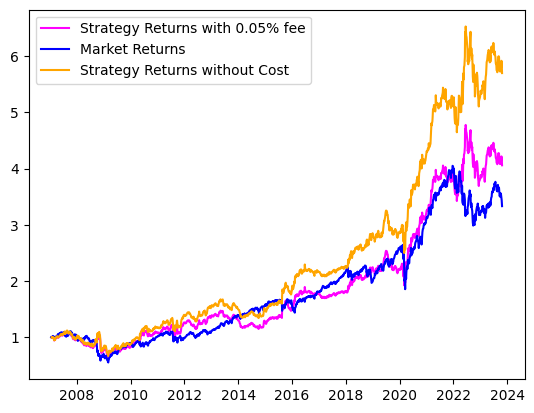

In [116]:
plt.plot((1+cost_analysis["Actual_Cummulative_Returns"].pct_change()).cumprod(), "magenta", label = f"Strategy Returns with {fee*100}% fee")
plt.plot(np.exp(good_returns[best_set][2]["Actual_Returns"]).cumprod(), "blue", label = "Market Returns")
plt.plot(np.exp(cost_analysis["trend_Strategy_Returns"]).cumprod(), "orange", label = "Strategy Returns without Cost")
plt.legend()

- We can observe that we would have made a smaller overall gain instead. This gain will be further reduced if other costs were to be incorporated.